In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
df = pd.read_parquet('/content/drive/MyDrive/BA820 Project/Dataset/merged_data1.parquet')
print(df.head())

                 user_id                 name_x           time  rating  \
0  116404531305033742641  Zygintas Krasodomskis  1568240961087     5.0   
1  101806853201406057266            Olga Harbar  1590701094969     3.0   
2  110623621391484838669             Amit Patel  1558575636156     4.0   
3  114893265310260912873         Jerry Cardillo  1535435901765     4.0   
4  106080008682473967828           Jake Moreira  1487952273508     4.0   

                                                text  resp  \
0                     Honestly, best burgers in town  None   
1                                               None  None   
2                                               None  None   
3                                               None  None   
4  This place gave me a good sanwich and a fry bu...  None   

                                 gmap_id                 name_y  \
0  0x89e37a19e56a4565:0xbb2aefc495e8c505              Five Guys   
1  0x89e45acc1861f709:0x9ccc502a907ff195  Price 

In [3]:
df.isnull().sum()

,0
user_id,0
name_x,0
time,0
rating,0
text,391626
resp,756452
gmap_id,0
name_y,0
address,0
latitude,0


In [4]:
df['text'] = df['text'].fillna("N/A")
df['resp'] = df['resp'].fillna("N/A")

In [5]:
df.isnull().sum()

,0
user_id,0
name_x,0
time,0
rating,0
text,0
resp,0
gmap_id,0
name_y,0
address,0
latitude,0


In [6]:
numerical_cols = ['rating', 'latitude', 'longitude', 'avg_rating', 'num_of_reviews']
categorical_cols = ['category']
text_cols = ['text', 'resp']

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_scaled = scaler.fit_transform(df[numerical_cols])

num_df = pd.DataFrame(num_scaled, columns=[f"num_feature_{i}" for i in range(num_scaled.shape[1])])

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
category_encoded = mlb.fit_transform(df[categorical_cols])

# Convert to DataFrame with proper column names
category_df = pd.DataFrame(category_encoded, columns=mlb.classes_)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer_text = TfidfVectorizer(stop_words='english', max_features=50)
vectorizer_resp = TfidfVectorizer(stop_words='english', max_features=50)

text_transformed = vectorizer_text.fit_transform(df['text'])
resp_transformed = vectorizer_resp.fit_transform(df['resp'])

# Convert to DataFrame
text_df = pd.DataFrame(text_transformed.toarray(), columns=[f"text_{col}" for col in vectorizer_text.get_feature_names_out()])
resp_df = pd.DataFrame(resp_transformed.toarray(), columns=[f"resp_{col}" for col in vectorizer_resp.get_feature_names_out()])

Overview of businesses by Hierarchical Clustering

In [10]:
from scipy.cluster.hierarchy import linkage, fcluster
df_sampled = num_df.sample(frac=0.01, random_state=42)

n_clusters = 3

Z = linkage(df_sampled, 'ward') #Try different ones.
df_sampled['cluster_labels'] = fcluster(Z, n_clusters, criterion='maxclust').astype(str)

<Axes: xlabel='num_feature_2', ylabel='num_feature_1'>

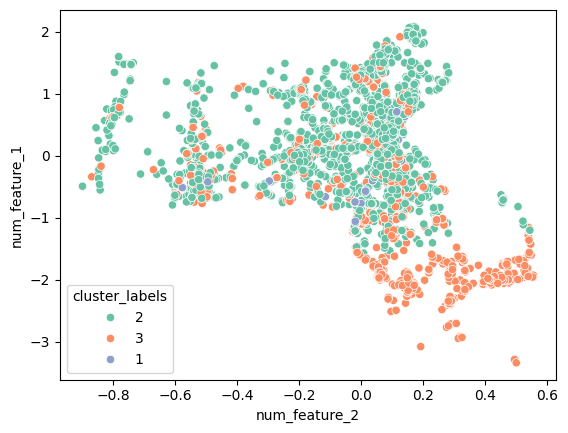

In [11]:
import seaborn as sns
sns.scatterplot(df_sampled, x = 'num_feature_2', y = 'num_feature_1', hue='cluster_labels', palette="Set2")

Cluster 1: Businesses in mid-sized communities
Cluster 2: Businesses in Greater Boston Area
Cluster 3: Businesses near Cape Cod

HDBSCAN

In [12]:
import hdbscan
region = ['num_feature_2', 'num_feature_1']
df_sampled_hdbscan = num_df[region].sample(frac=0.1, random_state=42)
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=80,
    #min_samples=100,
    cluster_selection_epsilon=0.3
)
clusters = clusterer.fit_predict(df_sampled_hdbscan)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [20]:
from sklearn.metrics import silhouette_score

labels_ = clusterer.labels_
mask = (labels_ != -1)
silhouette = silhouette_score(df_sampled_hdbscan[mask], labels_[mask])
print("Silhouette Score (without outliers):", silhouette)

Silhouette Score (without outliers): 0.3779949299924797
